# Node Classification Using Attributed Node Embeddings (TENE) 

#### Loading Modules & Voting Network 

In [15]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score
from sklearn.model_selection import train_test_split
import networkx as nx
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import random
from karateclub.node_embedding.attributed import TENE
from sklearn.tree import DecisionTreeClassifier
from karateclub.node_embedding.structural import Role2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

from recommend.pmf import PMF
from recommend.bpmf import BPMF
from numpy.random import RandomState
from recommend.utils.evaluation import RMSE
rand_state = RandomState(0)

df = pd.read_csv("wikiRfA.csv")
labT = LabelEncoder()
df['TARGET']=labT.fit_transform(df['TARGET'])
df['TARGET']=df['TARGET']+2
labS=LabelEncoder()
df['SOURCE']=labS.fit_transform(df['SOURCE'])
df['SOURCE']=df['SOURCE']+2

#### Splitting Voting Network & Extracting Node Centrality 

In [16]:
data_np=df.values
n_user = max(data_np[:,0])
n_item = max(data_np[:,0])
data_np[:, (0, 1)] -= 1
train_pct = 0.9
rand_state.shuffle(data_np)
train_size = int(train_pct * data_np.shape[0])
train = data_np[:train_size]
test = data_np[train_size:]

training_data=pd.DataFrame(train, columns=['SOURCE','TARGET','VOTE','RESULT'])
testing_data=pd.DataFrame(test, columns=['SOURCE','TARGET','VOTE','RESULT'])

training_data['in_edges'] = training_data.groupby('TARGET')['VOTE'].transform('count')
training_data['out_edges'] = training_data.groupby('SOURCE')['VOTE'].transform('count')
training_data['avg_in_weight'] = training_data.groupby('TARGET')['VOTE'].transform('mean')
training_data['avg_out_weight'] = training_data.groupby('SOURCE')['VOTE'].transform('mean')

In [17]:
Training_target_features = {}
for index, row in training_data.iterrows():
    node_name = row['TARGET']
    in_edges = row['in_edges']
    out_edges = row['out_edges']
    avg_in_weight = row['avg_in_weight']
    avg_out_weight = row['avg_out_weight']
    Training_target_features[node_name] = [in_edges, out_edges, avg_in_weight, avg_out_weight]

Training_source_features = {}
for index, row in training_data.iterrows():
    node_name = row['SOURCE']
    in_edges = row['in_edges']
    out_edges = row['out_edges']
    avg_in_weight = row['avg_in_weight']
    avg_out_weight = row['avg_out_weight']
    Training_source_features[node_name] = [in_edges, out_edges, avg_in_weight, avg_out_weight]

#Constructing Graph
Training_graph = nx.DiGraph()
for index, row in training_data.iterrows():
    source = row['SOURCE']
    target = row['TARGET']
    voting = row['VOTE']
    result = row['RESULT']
    Training_graph.add_node(source)
    Training_graph.add_node(target)
    Training_graph.nodes[target]['vote'] = result
    Training_graph.add_edge(source, target, label=voting)

#### Using TENE to Extract Probabilistic Node Embeddings of Training Network  

In [18]:
nx.convert_node_labels_to_integers(Training_graph, first_label=0 , ordering ='sorted',label_attribute ="node_type")
mapping = dict (zip(Training_graph, range(len(Training_graph.nodes))))
G_train = nx.relabel_nodes(Training_graph, mapping)

In [19]:
x = np.random.uniform(-1, 1, (int(G_train.number_of_nodes()), int(G_train.number_of_nodes())))

model = TENE()
model.fit(G_train, x)
node_embeddings=model.get_embedding()

#### Constructing Feature Vector of Training Network 

In [20]:
np.set_printoptions(suppress=True)
X_train = []
y_train = []
for node in G_train.nodes():
    if node in Training_target_features:
        node_embedding = node_embeddings[node]
        in_edges = Training_target_features[node][0]
        out_edges = Training_target_features[node][1]
        avg_in_weight = Training_target_features[node][2]
        avg_out_weight = Training_target_features[node][3]
        X_train.append(np.concatenate([node_embedding, [in_edges], [out_edges], [avg_in_weight], [avg_out_weight]]))
        y_train.append(Training_graph.nodes[node]['vote'])

#### Classifier Training on basis of Feature Vector 

In [21]:
#clf = LogisticRegression(solver='newton-cg',penalty='none',max_iter=1000)
clf=DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

#### Using TENE to Extract Probabilistic Node Embeddings of Test Network 

In [22]:
testing_data['in_edges'] = testing_data.groupby('TARGET')['VOTE'].transform('count')
testing_data['out_edges'] = testing_data.groupby('SOURCE')['VOTE'].transform('count')
testing_data['avg_in_weight'] = testing_data.groupby('TARGET')['VOTE'].transform('mean')
testing_data['avg_out_weight'] = testing_data.groupby('SOURCE')['VOTE'].transform('mean')

Test_source_features = {}
for index, row in testing_data.iterrows():
    node_name = row['SOURCE']
    in_edges = row['in_edges']
    out_edges = row['out_edges']
    avg_in_weight = row['avg_in_weight']
    avg_out_weight = row['avg_out_weight']
    Test_source_features[node_name] = [in_edges, out_edges, avg_in_weight, avg_out_weight]
    
Test_target_features = {}
for index, row in testing_data.iterrows():
    node_name = row['TARGET']
    in_edges = row['in_edges']
    out_edges = row['out_edges']
    avg_in_weight = row['avg_in_weight']
    avg_out_weight = row['avg_out_weight']
    Test_target_features[node_name] = [in_edges, out_edges, avg_in_weight, avg_out_weight]

Test_graph = nx.DiGraph()
for index, row in testing_data.iterrows():
    source = row['SOURCE']
    target = row['TARGET']
    voting = row['VOTE']
    result = row['RESULT']
    Test_graph.add_node(source)
    Test_graph.add_node(target)
    Test_graph.nodes[target]['vote'] = result
    Test_graph.add_edge(source, target, label=voting)

#### Constructing Feature Vector for Test Network 

In [ ]:
nx.convert_node_labels_to_integers(Test_graph, first_label=0 , ordering ='sorted',label_attribute =" node_type ")
mapping = dict (zip(Test_graph, range(len(Test_graph.nodes))))
G_test = nx.relabel_nodes(Test_graph, mapping)

y = np.random.uniform(-1, 1, (int(G_test.number_of_nodes()), int(G_test.number_of_nodes())))

model = TENE()
model.fit(G_test, y)
test_node_embeddings=model.get_embedding()

np.set_printoptions(suppress=True)
X_test = []
y_test = []
for node in G_test.nodes():
    if node in Test_target_features:
        node_embedding = test_node_embeddings[node]
        in_edges = Test_target_features[node][0]
        out_edges = Test_target_features[node][1]
        avg_in_weight = Test_target_features[node][2]
        avg_out_weight = Test_target_features[node][3]
        X_test.append(np.concatenate([node_embedding, [in_edges], [out_edges], [avg_in_weight], [avg_out_weight]]))
        y_test.append(Test_graph.nodes[node]['vote'])

#### Classifier Evaluation 

In [ ]:
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[::,1]

print(classification_report(y_test, y_pred))
print("Precision/Accuracy:", precision_score(y_test, y_pred), accuracy_score(y_test, y_pred) )
cm = confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
cm_display.plot()
plt.show()

#### Plotting ROC Curve 

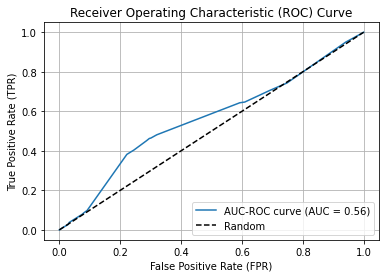

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
interp_fpr = np.linspace(0, 1, num=90000000)
interp_tpr = np.interp(interp_fpr, fpr, tpr)
auc_roc = roc_auc_score(y_test, y_prob)

plt.plot(fpr, tpr, label='AUC-ROC curve (AUC = {:.2f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()